# Lab 1, Larry Li, LL2947

In [45]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
data_dir = '../data/data.dat'

In [3]:
#reading in
data = np.loadtxt(data_dir, skiprows=7, delimiter='\t')

In [4]:
distance = data[:, 0]
distance_err = data[:, 1]
velocity = data[:, 2]/1000
original_data = [distance, distance_err, velocity]

In [20]:
def h_0_to_age_conversion(h_0):
    """
    given h_0 in [1000*mpc*s/km]
    return age of universe in billion years
    """
    km_in_mpc = 3.0856776e19
    seconds_in_year = 3.15576e7
    age = (h_0)*(1/1000.0)*(km_in_mpc)*(1/seconds_in_year)*(1/1e9)
    return age

### Original plot

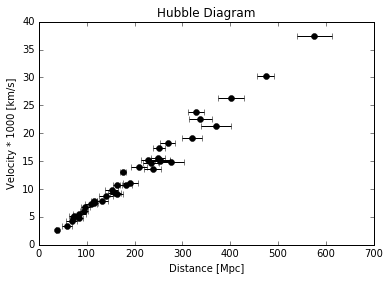

In [35]:
fig0 = plt.figure()
ax1 = fig0.add_subplot(111)
ax1.errorbar(distance, velocity, xerr=distance_err, color='black', fmt='o')
ax1.set_ylabel('Velocity * 1000 [km/s]')
ax1.set_xlabel('Distance [Mpc]')
ax1.set_title('Hubble Diagram')
plt.show()
fig0.savefig('../figures/original.pdf')

### Rearranged plot (pt. 2)

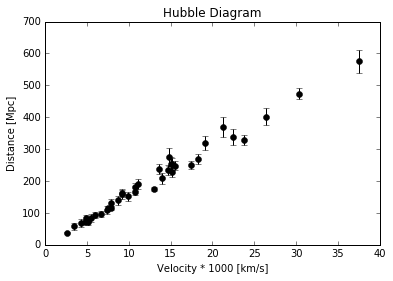

In [22]:
# 2
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.errorbar(velocity, distance, yerr=distance_err, color='black', fmt='o')
ax1.set_xlabel('Velocity * 1000 [km/s]')
ax1.set_ylabel('Distance [Mpc]')
ax1.set_title('Hubble Diagram')
plt.show()

### NP polyfit & residual plot (pt. 3)

In [7]:
# 3
poly_coef = np.polyfit(velocity, distance, 1)

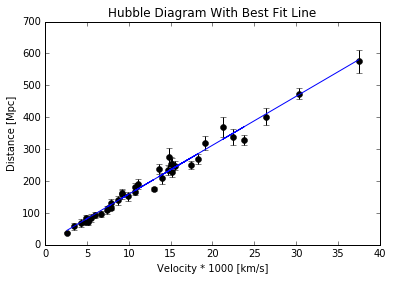

In [36]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.errorbar(velocity, distance, yerr=distance_err, color='black', fmt='o')
ax1.plot(velocity, velocity * poly_coef[0] + poly_coef[1])
ax1.set_xlabel('Velocity * 1000 [km/s]')
ax1.set_ylabel('Distance [Mpc]')
ax1.set_title('Hubble Diagram With Best Fit Line')
plt.show()
fig2.savefig('../figures/flipped_with_fit_line.pdf')

In [9]:
residuals = distance - (velocity * poly_coef[0] + poly_coef[1])

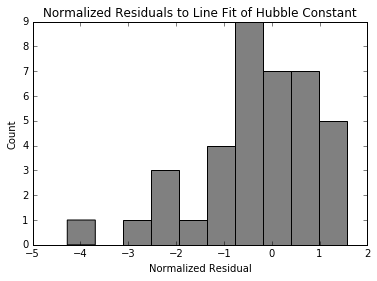

In [37]:
fig3 = plt.figure()
ax1 = fig3.add_subplot(111)
ax1.hist(residuals/distance_err, color='grey')
ax1.set_xlabel('Normalized Residual')
ax1.set_ylabel('Count')
ax1.set_title('Normalized Residuals to Line Fit of Hubble Constant')
plt.show()
fig3.savefig('../figures/normalized_residuals.pdf')

### Unweighted normal equation (pt. 4)

In [11]:
def create_x_mat(x):
    x_0 = np.power(x, 0)
    big_x = np.mat(np.vstack((x_0, x)))
    return big_x.T
    
def create_y_mat(y):
    return np.mat(y).T
    
def beta_unweighted(x, y):
    x_mat = create_x_mat(x)
    y_mat = create_y_mat(y)
    return np.array((inv(x_mat.T*x_mat)*x_mat.T*y_mat).T)[0]

In [12]:
print 'FROM numpy polyfit: {}'.format(np.polyfit(velocity, distance, 1)[::-1])
print 'FROM my unweighted normal eq solver: {}'.format(beta_unweighted(velocity, distance))

FROM numpy polyfit: [  5.16280981  15.35262538]
FROM my unweighted normal eq solver: [  5.16280981  15.35262538]


### Polyfit with cov matrix (pt. 5)

In [13]:
poly_coef_w, poly_cov_w = np.polyfit(velocity, distance, 1, w=1/distance_err, cov=True)

In [14]:
print 'FROM numpy polyfit with error weighting, the coef: ', poly_coef_w
print 'FROM numpy polyfit with error weighting, the covariance matrix is:\n', poly_cov_w

FROM numpy polyfit with error weighting, the coef:  [ 15.30758886  -0.64273122]
FROM numpy polyfit with error weighting, the covariance matrix is:
[[ 0.1104283  -0.76154614]
 [-0.76154614  8.10422169]]


### Errors from cov matrix (pt. 6)

In [16]:
poly_1st_deg_err = poly_cov_w[0][0]**.5
poly_0th_deg_err = poly_cov_w[1][1]**.5

print 'Age of the universe from the hubble constant: {0} +- {1} billion years'\
    .format(h_0_to_age_conversion(poly_coef_w[0]), h_0_to_age_conversion(poly_1st_deg_err))

Age of the universe from the hubble constant: 14.9676414086 +- 0.324927733618 billion years


### Data perturbation (pt. 8)

In [17]:
def create_perturbed_data(data, weight):
    perturb = np.random.normal(data, weight)
    return perturb

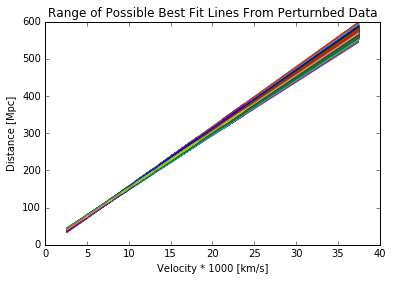

In [68]:
fig8 = plt.figure()
ax1 = fig8.add_subplot(111)

run_num = 1000
gradient = []
for i in range(run_num):
    new_data = create_perturbed_data(distance, distance_err)
    new_fit_coef = np.polyfit(velocity, new_data, 1, w=(1/distance_err))
    
    gradient.append(new_fit_coef[0])

    ax1.plot(velocity, velocity * new_fit_coef[0] + new_fit_coef[1])
    ax1.set_alpha(.1)
    ax1.set_xlabel('Velocity * 1000 [km/s]')
    ax1.set_ylabel('Distance [Mpc]')
    ax1.set_title('Range of Possible Best Fit Lines From Perturnbed Data')
plt.show()

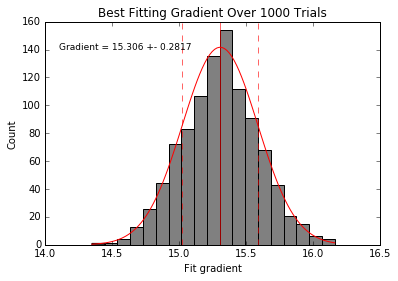

In [95]:
fig8b = plt.figure()
ax1 = fig8b.add_subplot(111)

bins = np.linspace(np.min(gradient), np.max(gradient), 20)
ax1.hist(gradient, bins, color='grey')
ax1.set_xlabel('Fit gradient')
ax1.set_ylabel('Count')
ax1.set_title('Best Fitting Gradient Over 1000 Trials')

scale = 100
gradient_range = np.linspace(np.min(gradient), np.max(gradient), 100)
ax1.plot(gradient_range, mlab.normpdf(gradient_range, np.mean(gradient), np.std(gradient))*scale, color='red')
ax1.text(14.1, 140, 'Gradient = {0:05.3f} +- {1:04.4f}'.format(np.mean(gradient), np.std(gradient)), fontsize=9)

ax1.plot([np.mean(gradient), np.mean(gradient)], [0,160]\
         , alpha=.6, color='red')
ax1.plot([np.mean(gradient)-np.std(gradient), np.mean(gradient)-np.std(gradient)], [0,160]\
         , '--', alpha=.6, color='red')
ax1.plot([np.mean(gradient)+np.std(gradient), np.mean(gradient)+np.std(gradient)], [0,160]\
         , '--', alpha=.6, color='red')
plt.show()

fig8b.savefig('../figures/best_fit_gradient.pdf')